## Shape violation data by number of violations for a contaminant and year

Notes about this Logistic Regression model:
1. To run this notebook, load SDWIS csv data files into the folder ../../../data/sdwis/SDWIS
2. The input data set is water systems that have had a violation in the past, NOT all water systems
3. The features and target variable are generated calling the function get_violations_by_year_df, # violations for current_year will become the target variable (0_yrs_ago)
4. TODO: Improve model performance by adding other water system features

In [1]:
import os
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.model_selection import train_test_split

In [2]:
# Label data with full year, e.g., 2012 for 01-JUL-12, 1990 for 01-JUN-90
def get_full_year(ddmmmyy):
    full_year = 0
    date_parts = ddmmmyy.split('-')
    if len(date_parts) == 3:
        if (int(date_parts[2]) <= 19):
            full_year = int('20' + date_parts[2])
        else:
            full_year = int('19' + date_parts[2])
    return full_year

In [3]:
def get_full_year_for_row(row):
    return get_full_year(row['VIOLATION.COMPL_PER_BEGIN_DATE'])

In [4]:
# calculate years ago from input 'current_year'
def get_years_ago(row, current_year):
    row_year = get_full_year(row['VIOLATION.COMPL_PER_BEGIN_DATE'])
    return str(current_year - row_year) + '_yrs_ago'

In [5]:
# pass in empty contaminant_codes for ALL contaminants
def get_violations_by_year_df(viol_df, contaminant_codes, current_year):
    # generate year column for filtering
    viol_df = viol_df[['VIOLATION.PWSID', 'VIOLATION.CONTAMINANT_CODE', 'VIOLATION.COMPL_PER_BEGIN_DATE']]
    viol_df.loc[:, 'VIOLATION.YEAR'] = viol_df.apply(get_full_year_for_row, axis=1)
    
    # filter 10 years back from current year
    viol_df = viol_df[viol_df['VIOLATION.YEAR'] >= current_year - 10]
    viol_df.loc[:, 'VIOLATION.YEARS_AGO'] = viol_df.apply(get_years_ago, args=(current_year, ), axis=1)
    viol_df = viol_df.drop(['VIOLATION.COMPL_PER_BEGIN_DATE', 'VIOLATION.YEAR'], axis=1)
    
    # filter by contaminant codes
    if len(contaminant_codes) > 0:
        viol_df = viol_df[viol_df['VIOLATION.CONTAMINANT_CODE'].isin(contaminant_codes)]
    viol_df = viol_df.drop(['VIOLATION.CONTAMINANT_CODE'], axis=1)
    
    # group by water system and year, and return counts
    viol_grouped = viol_df.groupby(['VIOLATION.PWSID', 'VIOLATION.YEARS_AGO'])
    viol_by_year = viol_grouped.size().unstack().fillna(0)
    
    return viol_by_year

In [6]:
# read input files
data_dir = '../../../data'
# print(os.listdir(data_dir))

# assumes csv files are in folder ../../../data/sdwis/SDWIS
viol = pd.read_csv(os.path.join(data_dir + '/sdwis/SDWIS', 'VIOLATION.csv'), sep=',', \
                  dtype={'VIOLATION.CONTAMINANT_CODE': np.str}, low_memory=False)
water_system = pd.read_csv(os.path.join(data_dir + '/sdwis/SDWIS', 'WATER_SYSTEM.csv'), low_memory=False)
contaminant_codes = pd.read_csv(os.path.join(data_dir + '/sdwis', 'contaminant-codes.csv'), sep=',')

In [7]:
# get contaminant code
contaminant_codes[contaminant_codes['NAME'].str.contains("lead", case=False)]

,CODE,NAME,SCIENTIFIC_NAME,TYPE_CODE
39,1030,LEAD,NaN,IOC
713,4370,82-LEAD-203,NaN,RA
714,4372,82-LEAD-210,NaN,RA
722,5000,LEAD & COPPER RULE,NaN,RL
767,PB90,LEAD SUMMARY,NaN,IOC


### TODO: Get rid of warning below

In [8]:
viol_by_yr = get_violations_by_year_df(viol, ['1030', '5000', 'PB90'], 2017)

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
viol_by_yr.shape

(24556, 12)

### These are the features:

In [10]:
water_system = pd.read_csv(os.path.join(data_dir + '/sdwis/SDWIS', 'WATER_SYSTEM.csv'), low_memory=False)
water_system = water_system[['WATER_SYSTEM.PWSID', 'WATER_SYSTEM.STATE_CODE', 'WATER_SYSTEM.PWS_TYPE_CODE', \
                             'WATER_SYSTEM.POPULATION_SERVED_COUNT', 'WATER_SYSTEM.SERVICE_CONNECTIONS_COUNT']]
water_system = water_system.merge(viol_by_yr, left_on='WATER_SYSTEM.PWSID', right_on='VIOLATION.PWSID')
water_system = water_system.drop(['WATER_SYSTEM.PWSID'], axis=1)
water_system.head()

,WATER_SYSTEM.STATE_CODE,WATER_SYSTEM.PWS_TYPE_CODE,WATER_SYSTEM.POPULATION_SERVED_COUNT,WATER_SYSTEM.SERVICE_CONNECTIONS_COUNT,-1_yrs_ago,0_yrs_ago,10_yrs_ago,1_yrs_ago,2_yrs_ago,3_yrs_ago,4_yrs_ago,5_yrs_ago,6_yrs_ago,7_yrs_ago,8_yrs_ago,9_yrs_ago
0,NY,CWS,1496,522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,CO,NTNCWS,452,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0
2,PA,NTNCWS,275,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,IL,CWS,100,47,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,IL,CWS,60,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [11]:
water_system.loc[:, 'past_10_yrs'] = water_system['10_yrs_ago'] + water_system['9_yrs_ago'] \
    + water_system['8_yrs_ago'] + water_system['7_yrs_ago'] \
    + water_system['6_yrs_ago'] + water_system['5_yrs_ago'] \
    + water_system['4_yrs_ago'] + water_system['3_yrs_ago'] \
    + water_system['2_yrs_ago'] + water_system['1_yrs_ago'] \

In [12]:
water_system.head()

,WATER_SYSTEM.STATE_CODE,WATER_SYSTEM.PWS_TYPE_CODE,WATER_SYSTEM.POPULATION_SERVED_COUNT,WATER_SYSTEM.SERVICE_CONNECTIONS_COUNT,-1_yrs_ago,0_yrs_ago,10_yrs_ago,1_yrs_ago,2_yrs_ago,3_yrs_ago,4_yrs_ago,5_yrs_ago,6_yrs_ago,7_yrs_ago,8_yrs_ago,9_yrs_ago,past_10_yrs
0,NY,CWS,1496,522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,CO,NTNCWS,452,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,4.0
2,PA,NTNCWS,275,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,IL,CWS,100,47,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,IL,CWS,60,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0


,WATER_SYSTEM.POPULATION_SERVED_COUNT,WATER_SYSTEM.SERVICE_CONNECTIONS_COUNT,-1_yrs_ago,0_yrs_ago,10_yrs_ago,1_yrs_ago,2_yrs_ago,3_yrs_ago,4_yrs_ago,5_yrs_ago,6_yrs_ago,7_yrs_ago,8_yrs_ago,9_yrs_ago,past_10_yrs
WATER_SYSTEM.POPULATION_SERVED_COUNT,1.000000,0.815620,-0.004426,0.000767,-0.015771,-0.000520,0.008032,-0.014039,0.006051,-0.001350,-0.001049,-0.000023,0.005080,-0.000379,-0.003073
WATER_SYSTEM.SERVICE_CONNECTIONS_COUNT,0.815620,1.000000,-0.005356,0.002871,-0.016163,-0.000922,0.008791,-0.005013,0.009103,-0.001134,0.000173,0.000083,0.004658,-0.007493,-0.000841
-1_yrs_ago,-0.004426,-0.005356,1.000000,0.308220,-0.056960,0.113208,0.061601,0.034664,0.004671,-0.017813,-0.025918,-0.036549,-0.042147,-0.054432,0.013850
0_yrs_ago,0.000767,0.002871,0.308220,1.000000,-0.075730,0.222679,0.094857,0.091576,0.030328,-0.008362,-0.024147,-0.037567,-0.064269,-0.074880,0.072180
10_yrs_ago,-0.015771,-0.016163,-0.056960,-0.075730,1.000000,-0.090026,-0.071994,-0.071104,-0.080340,-0.040765,-0.033284,0.015333,0.043426,0.162071,0.160403
1_yrs_ago,-0.000520,-0.000922,0.113208,0.222679,-0.090026,1.000000,0.273696,0.103843,0.069069,0.021475,-0.016465,-0.030998,-0.050775,-0.077521,0.402002
2_yrs_ago,0.008032,0.008791,0.061601,0.094857,-0.071994,0.273696,1.000000,0.242806,0.091078,0.058053,0.035648,0.002705,-0.031407,-0.058300,0.491331
3_yrs_ago,-0.014039,-0.005013,0.034664,0.091576,-0.071104,0.103843,0.242806,1.000000,0.251190,0.116516,0.088355,0.028486,-0.052718,-0.060286,0.486482
4_yrs_ago,0.006051,0.009103,0.004671,0.030328,-0.080340,0.069069,0.091078,0.251190,1.000000,0.202921,0.131006,0.068912,-0.027942,-0.056542,0.471099
5_yrs_ago,-0.001350,-0.001134,-0.017813,-0.008362,-0.040765,0.021475,0.058053,0.116516,0.202921,1.000000,0.194159,0.093661,0.047323,0.000350,0.439373


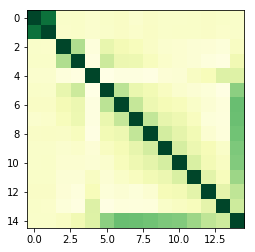

In [13]:
corr = water_system.corr()
plt.imshow(corr, cmap="YlGn", interpolation='nearest')
corr

### One Hot encode categoricals

In [14]:
water_state = water_system['WATER_SYSTEM.STATE_CODE']
water_state = water_state.fillna('State unknown')
encoder = LabelBinarizer(sparse_output=False)
water_state_cat = encoder.fit_transform(water_state)
water_state_cat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [15]:
water_pws_type = water_system['WATER_SYSTEM.PWS_TYPE_CODE']
water_pws_type = water_pws_type.fillna('Type unknown')
encoder = LabelBinarizer(sparse_output=False)
water_pws_type_cat = encoder.fit_transform(water_pws_type)
water_pws_type_cat.shape

(24556, 3)

## Run Logistic Regression

In [16]:
X = water_system[['10_yrs_ago','9_yrs_ago','8_yrs_ago','7_yrs_ago','6_yrs_ago','5_yrs_ago', \
    '4_yrs_ago', '3_yrs_ago', '2_yrs_ago', '1_yrs_ago']].values
X

array([[ 1.],
       [ 4.],
       [ 1.],
       ...,
       [ 2.],
       [10.],
       [ 1.]])

In [17]:
X = np.concatenate([X, water_state_cat, water_pws_type_cat], axis=1)
X.shape

(24556, 61)

In [18]:
# convert all non-zero values to 1
y = (water_system['0_yrs_ago'] >= 1).values.astype(np.int)
y.shape
y

array([0, 0, 0, ..., 0, 0, 0])

### Split data into training and test sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train, y_train)


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [20]:
# look at coefficients
np.abs(log_reg.coef_)

array([[0.5171979 , 0.42697811, 0.63769427, 0.03508376, 2.18820461,
        0.92801561, 0.20947845, 0.84255195, 0.32348844, 1.64057618,
        0.61368573, 0.37620583, 0.65396093, 0.69796583, 1.08625396,
        0.49172667, 0.74675725, 0.22479828, 0.22768529, 2.00262215,
        2.14614397, 0.94385336, 0.45721582, 0.57874145, 1.09106355,
        0.51399784, 0.01376079, 0.85999871, 1.4600276 , 2.04698887,
        0.24448779, 0.32424362, 1.3202766 , 0.67462872, 0.67912412,
        0.97569297, 0.16354123, 1.10412134, 0.37561502, 1.10432393,
        0.53948197, 1.02778509, 0.25003187, 1.68384594, 1.09328541,
        0.61994855, 0.23714681, 0.7668867 , 0.79314569, 0.86385875,
        1.42817629, 0.22417235, 1.84056319, 0.02474806, 0.1289111 ,
        0.18014686, 1.63277813, 1.34578907, 0.16418242, 0.10944213,
        0.82366939]])

In [21]:
#X_new = [X[2]]
#y_pred = log_reg.predict(X_new)
# probabilities sorted by target label
# y_proba = log_reg.predict_proba(X_new)
# y_proba

## Measure performance of model

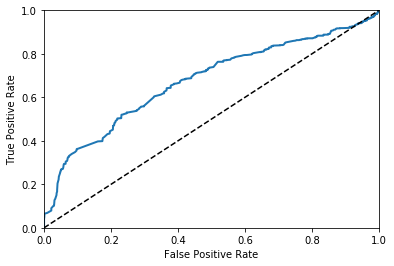

In [22]:
y_scores = log_reg.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [23]:
roc_auc_score(y_test, y_scores)

0.6751144193887411